# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_validate
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal, theme, element_text

In [20]:
penguins = sns.load_dataset("penguins")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [21]:
df = penguins.dropna().copy()
df.head()

X = df.drop(columns="bill_depth_mm")
y = df["bill_depth_mm"]

numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["number"]).columns.tolist()

In [22]:
numeric_prepro = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_prepro = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_prepro, numeric_features),
        ("cat", categorical_prepro, categorical_features),
    ],
    remainder="passthrough"
)

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [23]:
pipelines = {
    "Linear Regression": Pipeline([
        ("pre", preprocessor),
        ("model", LinearRegression())
    ]),
    "kNN (k=3)": Pipeline([
        ("pre", preprocessor),
        ("model", KNeighborsRegressor(n_neighbors=3))
    ]),
    "kNN (k=15)": Pipeline([
        ("pre", preprocessor),
        ("model", KNeighborsRegressor(n_neighbors=15))
    ]),
    "Decision Tree": Pipeline([
        ("pre", preprocessor),
        ("model", DecisionTreeRegressor(random_state=42))
    ]),
}

['Linear Regression', 'kNN (k=3)', 'kNN (k=15)', 'Decision Tree']

In [24]:
cv = KFold(n_splits=5, shuffle=True)
scoring = ["neg_root_mean_squared_error"]

In [25]:
results = []

for name, pipe in pipelines.items():
    cv_out = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    train_rmse = -cv_out["train_neg_root_mean_squared_error"]
    test_rmse  = -cv_out["test_neg_root_mean_squared_error"]

    results.append({
        "model": name,
        "train_rmse_mean": train_rmse.mean(),
        "train_rmse_std":  train_rmse.std(ddof=1),
        "test_rmse_mean":  test_rmse.mean(),
        "test_rmse_std":   test_rmse.std(ddof=1),
        "cv_folds": cv.get_n_splits()
    })

metrics_df = pd.DataFrame(results).sort_values("test_rmse_mean").reset_index(drop=True)
metrics_df


,model,train_rmse_mean,train_rmse_std,test_rmse_mean,test_rmse_std,cv_folds
0,Linear Regression,0.778310,0.015062,0.813577,0.059399,5
1,kNN (k=15),0.775420,0.026753,0.822462,0.112523,5
2,kNN (k=3),0.643562,0.026939,0.900933,0.086411,5
3,Decision Tree,0.015588,0.014230,1.143588,0.105844,5


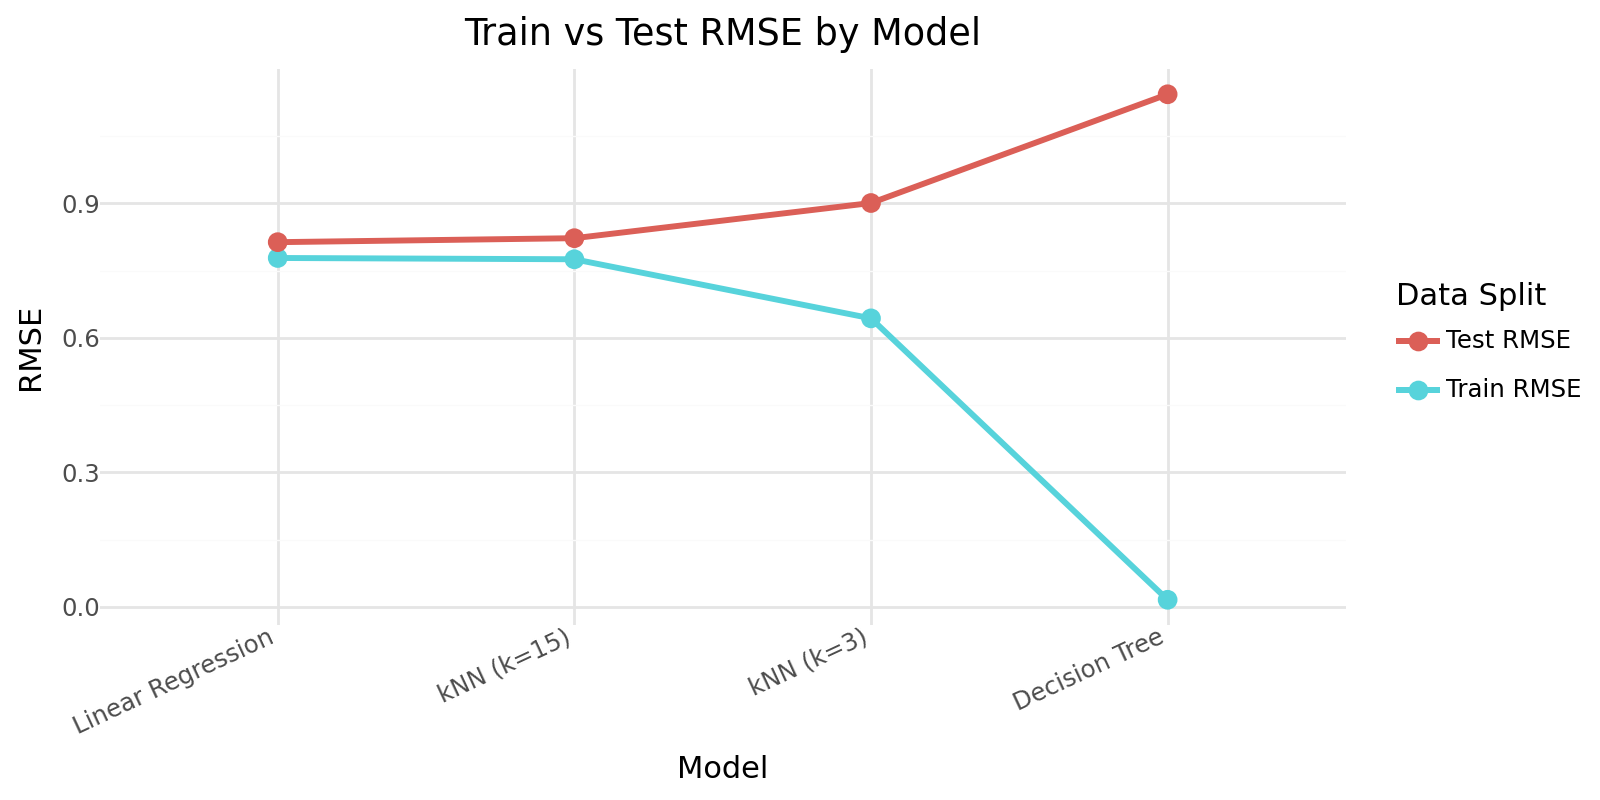

In [26]:
long_df = metrics_df.melt(
    id_vars="model",
    value_vars=["train_rmse_mean", "test_rmse_mean"],
    var_name="split",
    value_name="rmse"
)

long_df["split"] = long_df["split"].map({
    "train_rmse_mean": "Train RMSE",
    "test_rmse_mean": "Test RMSE"
})

long_df["model"] = pd.Categorical(long_df["model"], categories=metrics_df["model"], ordered=True)

plot = (
    ggplot(long_df, aes(x="model", y="rmse", color="split", group="split"))
    + geom_line(size=1.2)
    + geom_point(size=3)
    + theme_minimal()
    + theme(
        figure_size=(8, 4),
        axis_text_x=element_text(rotation=25, ha="right")
    )
    + labs(
        title="Train vs Test RMSE by Model",
        x="Model",
        y="RMSE",
        color="Data Split"
    )
)

plot

In [27]:
best_row = metrics_df.loc[metrics_df["test_rmse_mean"].idxmin()]
best_model_name = best_row["model"]

print("Best model by mean CV test RMSE:")
print(f"  {best_model_name}  |  Test RMSE: {best_row['test_rmse_mean']:.3f} ± {best_row['test_rmse_std']:.3f}")

Best model by mean CV test RMSE:
  Linear Regression  |  Test RMSE: 0.814 ± 0.059
